In [26]:
import dgl
import torch
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx


def plot_dgl_graph(dgl_graph):
    """
    绘制 DGL 图对象。
    
    参数:
    - dgl_graph (dgl.DGLGraph): 要绘制的 DGL 图对象。
    """
    # 将 DGL 图转换为 NetworkX 图
    nx_graph = dgl_graph.to_networkx()
    labels = dgl_graph.ndata.get('orig_id', None)
    
    if labels is not None:
        labels = {i: labels[i].item() for i in range(len(labels))}
    else:
        labels = {i: i for i in range(len(dgl_graph.nodes()))}
    
    # 绘图
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(nx_graph)  # 节点位置布局
    nx.draw(nx_graph, pos, labels=labels, with_labels=True, node_color='skyblue', node_size=500, edge_color='gray', font_size=15, font_weight='bold')
    plt.title('Graph Visualization')
    plt.show()

def check_graph_connectivity(graph):
    # 将 DGL 图转换为 NetworkX 图
    nx_graph = graph.to_networkx().to_undirected()

    # 使用 NetworkX 检查连通性
    if nx.is_connected(nx_graph):
        print("The graph is connected.")
    else:
        connected_components = list(nx.connected_components(nx_graph))
        print(f"The graph is not connected. It has {len(connected_components)} components.")
        print("Sizes of each component:", [len(comp) for comp in connected_components])

# 打印子图的信息
def print_subgraph_info(subgraph):
    print("Nodes in subgraph:", subgraph.nodes())
    print("Edges in subgraph:", subgraph.edges())
    print("Node features:", subgraph.ndata)
    print("Edge features:", subgraph.edata)

Nodes in the graph: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Edges in the graph: (tensor([0, 2, 2, 1, 3, 2, 4, 5, 4, 6, 7, 7, 6, 8, 7]), tensor([2, 0, 3, 3, 1, 4, 2, 3, 6, 4, 5, 6, 8, 6, 9]))


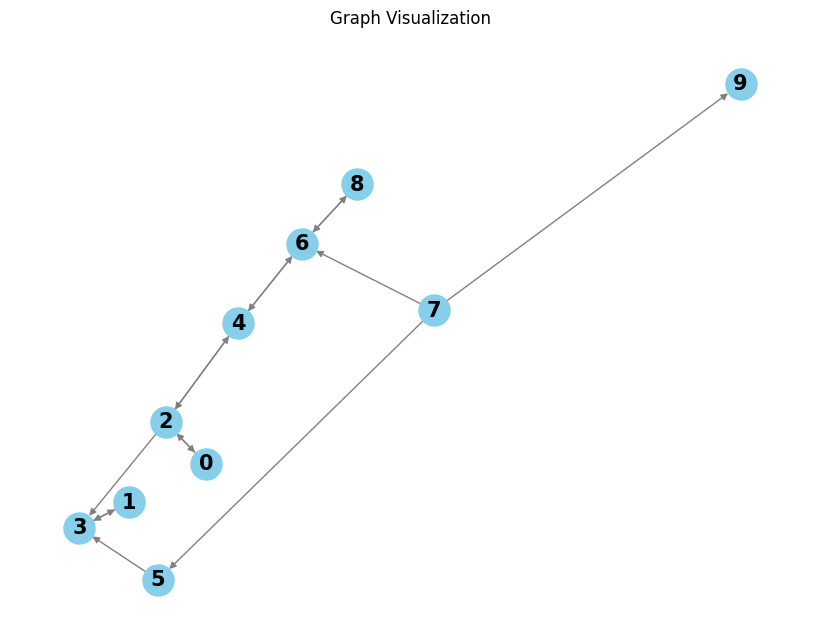

In [27]:
# 定义图的边
# src_nodes = torch.tensor([0, 1, 2, 3, 4])  # 起始节点
# dst_nodes = torch.tensor([1, 3, 3, 4, 5])  # 结束节点

src_nodes = torch.tensor([0, 2, 2, 1, 3, 2, 4, 5, 4, 6, 7, 7, 6, 8, 7])  # 起始节点
dst_nodes = torch.tensor([2, 0, 3, 3, 1, 4, 2, 3, 6, 4, 5, 6, 8, 6, 9])  # 结束节点


# 创建图对象
g = dgl.graph((src_nodes, dst_nodes))

# 图是无向的，所以添加反向边
# g = dgl.to_bidirected(g)

# 打印图的信息
print("Nodes in the graph:", g.nodes())
print("Edges in the graph:", g.edges())
plot_dgl_graph(g)

In [28]:
partition = dgl.distributed.partition_graph(g, graph_name='test', num_parts=2, out_path='./test/', num_hops=1, return_mapping=True, balance_edges=False) 

Converting to homogeneous graph takes 0.002s, peak mem: 41.253 GB
Convert a graph into a bidirected graph: 0.000 seconds, peak memory: 41.253 GB
Construct multi-constraint weights: 0.000 seconds, peak memory: 41.253 GB
Metis partitioning: 0.000 seconds, peak memory: 41.253 GB
Assigning nodes to METIS partitions takes 0.001s, peak mem: 41.253 GB
Reshuffle nodes and edges: 0.001 seconds
Split the graph: 0.000 seconds
Construct subgraphs: 0.016 seconds
Splitting the graph into partitions takes 0.017s, peak mem: 47.603 GB
part 0 has 7 nodes and 5 are inside the partition
part 0 has 7 edges and 6 are inside the partition
part 1 has 7 nodes and 5 are inside the partition
part 1 has 10 edges and 9 are inside the partition
Save partitions: 0.002 seconds, peak memory: 48.580 GB
There are 15 edges in the graph and 0 edge cuts for 2 partitions.


[01:03:48] /opt/dgl/src/graph/transform/metis_partition_hetero.cc:89: Partition a graph with 10 nodes and 20 edges into 2 parts and get 2 edge cuts


Nodes in subgraph: tensor([0, 1, 2, 3, 4, 5, 6])
Edges in subgraph: (tensor([1, 5, 0, 2, 3, 3, 3]), tensor([0, 1, 1, 1, 2, 4, 6]))
Node features: {'orig_id': tensor([1, 3, 5, 7, 9, 2, 6]), 'part_id': tensor([0, 0, 0, 0, 0, 1, 1]), 'inner_node': tensor([1, 1, 1, 1, 1, 0, 0], dtype=torch.uint8), '_ID': tensor([0, 1, 2, 3, 4, 6, 8])}
Edge features: {'inner_edge': tensor([1, 1, 1, 1, 1, 1, 0], dtype=torch.uint8), 'orig_id': tensor([ 4,  2,  3,  7, 10, 14, 11]), '_ID': tensor([ 0,  1,  2,  3,  4,  5, 12])}
nodes:   tensor([0, 1, 2, 3, 4, 5, 6])
NID:     tensor([0, 1, 2, 3, 4, 6, 8])
orig_id: tensor([1, 3, 5, 7, 9, 2, 6])
0 1 True
1 3 True
2 5 True
3 7 True
4 9 True
5 2 False
6 6 False


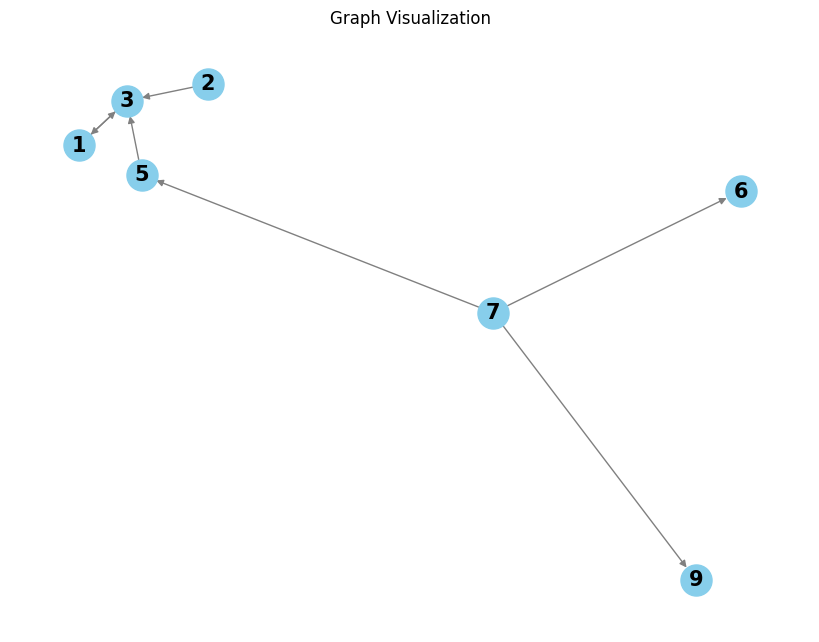

In [29]:
# 读取子图信息
g1, nodes_feats1, efeats1, gpb1, graph_name1, node_type1, etype1 = dgl.distributed.load_partition('./test/test.json', 0)

print_subgraph_info(g1)
print('nodes:  ', g1.nodes())
print('NID:    ', g1.ndata[dgl.NID])
print('orig_id:', g1.ndata['orig_id'])
for n,o,p in zip(g1.nodes(), g1.ndata['orig_id'], (g1.ndata['part_id'] == 0)): print(n.item(),o.item(), p.item())
plot_dgl_graph(g1)

Nodes in subgraph: tensor([0, 1, 2, 3, 4, 5, 6])
Edges in subgraph: (tensor([1, 0, 2, 1, 3, 2, 5, 4, 3, 1]), tensor([0, 1, 1, 2, 2, 3, 3, 3, 4, 6]))
Node features: {'orig_id': tensor([0, 2, 4, 6, 8, 7, 3]), 'part_id': tensor([1, 1, 1, 1, 1, 0, 0]), 'inner_node': tensor([1, 1, 1, 1, 1, 0, 0], dtype=torch.uint8), '_ID': tensor([5, 6, 7, 8, 9, 3, 1])}
Edge features: {'inner_edge': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0], dtype=torch.uint8), 'orig_id': tensor([ 1,  0,  6,  5,  9,  8, 11, 13, 12,  2]), '_ID': tensor([ 6,  7,  8,  9, 10, 11, 12, 13, 14,  1])}
nodes:   tensor([0, 1, 2, 3, 4, 5, 6])
NID:     tensor([5, 6, 7, 8, 9, 3, 1])
orig_id: tensor([0, 2, 4, 6, 8, 7, 3])
0 0 True
1 2 True
2 4 True
3 6 True
4 8 True
5 7 False
6 3 False


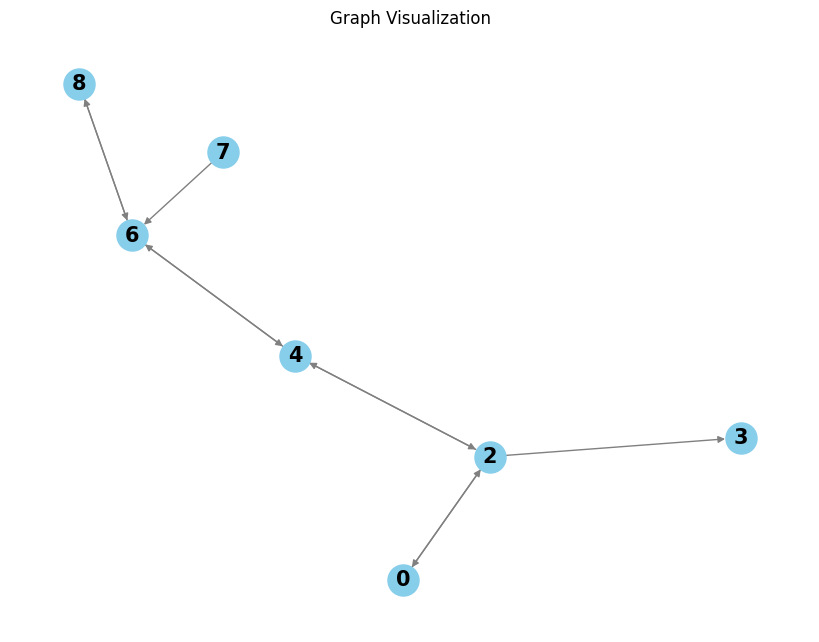

partid2nids of part 0:  tensor([0, 1, 2, 3, 4])
partid2nids of part 1:  tensor([5, 6, 7, 8, 9])


In [30]:
# 读取子图信息
g2, nodes_feats2, efeats2, gpb2, graph_name2, node_type2, etype2 = dgl.distributed.load_partition('./test/test.json', 1)

print_subgraph_info(g2)
print('nodes:  ', g2.nodes())
print('NID:    ', g2.ndata[dgl.NID])
print('orig_id:', g2.ndata['orig_id'])
for n,o,p in zip(g2.nodes(), g2.ndata['orig_id'], (g2.ndata['part_id'] == 1)): print(n.item(),o.item(), p.item())
plot_dgl_graph(g2)

print('partid2nids of part 0: ', gpb1.partid2nids(0))
print('partid2nids of part 1: ', gpb1.partid2nids(1))


In [31]:
halo_mask = (g2.ndata['part_id'] == 0)
print(halo_mask)
halo_nodes = g2.nodes()[halo_mask]
print(halo_nodes)
# out_edges = g2.out_edges(halo_nodes)
# print(out_edges)
out_edges = g2.out_edges(0)
print(out_edges)

# out_edges = g2.out_degrees([2])
# print(out_edges)

tensor([False, False, False, False, False,  True,  True])
tensor([5, 6])
(tensor([0]), tensor([1]))


In [32]:
belong_mask = (g2.ndata['part_id'] == 0)
halo_nodes = g2.nodes()[belong_mask]
fp_neighbor_ids = g2.out_edges(halo_nodes)[1]      # 当前分区图中，halo节点的前向邻居（即出边的目标节点）
fp_local_out_degrees = g2.out_degrees(halo_nodes)  # 当前分区图中，halo节点的出度
bp_neighbor_ids = g2.in_edges(halo_nodes)[0]       # 当前分区图中，halo节点的后向邻居（即入边的源节点）
bp_local_degrees = g2.in_degrees(halo_nodes)       # 当前分区图中，halo节点的入度

print('halo_nodes: ', halo_nodes)
print('fp_neighbor_ids: ', fp_neighbor_ids)
print('fp_local_out_degrees: ', fp_local_out_degrees)
print('bp_neighbor_ids: ', bp_neighbor_ids)
print('bp_local_degrees: ', bp_local_degrees)

print('*'*30)

# 前向聚合得分:
# - 计算前向邻居的全局度数 fp_global_out_degrees。
# - 对每个前向邻居的入度进行开方倒数的计算，并按节点的出度进行分割和求和，得到前向聚合得分 fp_agg_score。
# - 局部图中，每个halo节点的出度，占多少个该节点在全局图中入度的根号的倒数？
orig_id = g2.ndata['orig_id']
fp_global_in_degrees = g.in_degrees()[orig_id][fp_neighbor_ids].float().clamp(min=1) # 每个halo节点所指向的内点在全图中的入度数。值越大，说明这个内点在前向传播时要接收的数据越多。
fp_global_out_degrees = g.out_degrees()[orig_id][belong_mask]                        # 每个halo节点在全图中的出度数
score = torch.pow(fp_global_in_degrees, -0.5).split(fp_local_out_degrees.tolist())   # 其实是对fp_global_in_degrees的归一化（平方根的倒数）。值越大，score越小，说明这个halo节点会产生的影响越小，因为内点有很多其他接收的点。
fp_agg_score = torch.tensor([torch.sum(score[i] * torch.pow(fp_global_out_degrees[i].float().clamp(min=1), -0.5)) for i in range(len(score))])
print('fp_global_in_degrees: ', fp_global_in_degrees)
print('fp_global_out_degrees: ', fp_global_out_degrees)
print('score: ', score)
print('fp_agg_score: ', fp_agg_score)

print('*'*30)

# 后向聚合得分:
# - 计算后向邻居的全局度数 bp_global_degrees。
# - 对每个后向邻居的出度进行开方倒数的计算，并按节点的入度进行分割和求和，得到后向聚合得分 bp_agg_score。
bp_global_out_degrees = g.out_degrees()[orig_id][bp_neighbor_ids].float().clamp(min=1)
bp_global_in_degrees = g.in_degrees()[orig_id][belong_mask]
score = torch.pow(bp_global_out_degrees, -0.5).split(bp_local_degrees.tolist())
bp_agg_score = torch.tensor([torch.sum(score[i] * torch.pow(bp_global_in_degrees[i].float().clamp(min=1), -0.5)) for i in range(len(score))])
print('bp_global_out_degrees: ', bp_global_out_degrees)
print('bp_global_in_degrees: ', bp_global_in_degrees)
print('score: ', score)
print('bp_agg_score: ', bp_agg_score)

halo_nodes:  tensor([5, 6])
fp_neighbor_ids:  tensor([3])
fp_local_out_degrees:  tensor([1, 0])
bp_neighbor_ids:  tensor([1])
bp_local_degrees:  tensor([0, 1])
******************************
fp_global_in_degrees:  tensor([3.])
fp_global_out_degrees:  tensor([3, 1])
score:  (tensor([0.5774]), tensor([]))
fp_agg_score:  tensor([0.3333, 0.0000])
******************************
bp_global_out_degrees:  tensor([3.])
bp_global_in_degrees:  tensor([0, 3])
score:  (tensor([]), tensor([0.5774]))
bp_agg_score:  tensor([0.0000, 0.3333])


In [ ]:
nodes_to_remove_id = [3,]
nodes_to_remove_idx = [3]
ng2 = dgl.remove_nodes(g2, nodes_to_remove_id, store_ids=False)
print(ng2)
print('g2 nodes:', g2.nodes())
print('ng2 nodes:', ng2.nodes())
print('g2 NID:', g2.ndata[dgl.NID])
print('ng2 NID:', ng2.ndata[dgl.NID])

nodes_feats = {}
nodes_feats[dgl.NID] = g2.ndata[dgl.NID]
new_node_feats = {key: value[~torch.isin(torch.arange(value.size(0)), torch.tensor(nodes_to_remove_idx))] for key, value in nodes_feats.items()}
print(nodes_feats)
print(new_node_feats)



In [ ]:
import dgl
import torch

# 定义图的边
src_nodes = torch.tensor([0, 1, 2, 3, 4])  # 起始节点
dst_nodes = torch.tensor([1, 2, 3, 4, 5])  # 结束节点
# 创建图对象
g = dgl.graph((src_nodes, dst_nodes))
# 图是无向的，所以添加反向边
g = dgl.to_bidirected(g)

print("删除前的图：", g)
print("删除前的节点IDs：", g.nodes())

# 删除节点 2
g.remove_nodes(torch.tensor([2]))
print("删除后的图：", g)
print("删除后，新的节点IDs：", g.nodes())

print("#" * 50 )

# 删除节点 2，存储删除的节点 ID
g = dgl.graph((src_nodes, dst_nodes))
g = dgl.to_bidirected(g)
g.remove_nodes(torch.tensor([2]), store_ids=True)
print("删除后的图：", g)
print("删除后，新的节点IDs：", g.nodes())
print("删除后，保留的原始节点IDs：", g.ndata[dgl.NID])

In [ ]:
import redisai
import numpy as np
import time
import torch

con = redisai.Client(host='localhost', port=6379)

def bulk_get_tensors(con, tensors_list):
    pipe = con.pipeline(transaction=False)
    for tensor in tensors_list: pipe.tensorget(tensor)
    return pipe.execute()

In [ ]:
pipe = con.pipeline(transaction=False)
pipe = pipe.tensorset('x1', torch.randn((20000, 500)).numpy())
t1 = time.perf_counter()
pipe.execute()
print(time.perf_counter() - t1)

t1 = time.perf_counter()
con.tensorset('x2', torch.randn((20000, 500)).numpy())
print(time.perf_counter() - t1)

In [ ]:
t1 = time.perf_counter()
con.tensorget('x2', meta_only=True)
print(time.perf_counter() - t1)


In [ ]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt

# 测试数据生成函数
def generate_data(size):
    return range(size)  # 使用生成器来模拟大量数据

# 测试 np.fromiter 的性能
def test_fromiter_int32(data):
    start_time = time.time()
    np.fromiter(data, dtype=np.int32)
    return time.time() - start_time

# 测试 np.array 的性能（不计算 list 开销）
def test_array_no_list_overhead(data):
    data = list(data)  # 先将生成器转换为列表
    start_time = time.time()
    np.array(data, dtype=np.int32)  # 确保 dtype 为 int32
    return time.time() - start_time

# 测试 np.array 的性能（计算 list 开销）
def test_array_with_list_overhead(data):
    start_time = time.time()
    data = list(data)  # 生成器转换为列表的时间也包含在内
    np.array(data, dtype=np.int32)  # 确保 dtype 为 int32
    return time.time() - start_time

# 数据量从 10^1 到 10^9
data_sizes = [10**i for i in range(1, 8)]  # 从 10^1 到 10^7
results_comparison = []

for size in data_sizes:
    data = generate_data(size)
    
    # np.fromiter 性能测试
    fromiter_time_int32 = test_fromiter_int32(data)
    
    # np.array 性能测试（不计算 list 开销）
    data = generate_data(size)  # 重新生成数据
    array_time_no_list_overhead = test_array_no_list_overhead(data)
    
    # np.array 性能测试（计算 list 开销）
    data = generate_data(size)  # 重新生成数据
    array_time_with_list_overhead = test_array_with_list_overhead(data)
    
    results_comparison.append((size, fromiter_time_int32, array_time_no_list_overhead, array_time_with_list_overhead))

# 将结果显示为数据框
df_results_comparison = pd.DataFrame(results_comparison, columns=[
    'Data Size', 'Fromiter Time (s)', 'Array Time without List Overhead (s)', 'Array Time with List Overhead (s)'
])

# 绘制比较性能曲线
plt.figure(figsize=(10, 6))
plt.plot(df_results_comparison['Data Size'], df_results_comparison['Fromiter Time (s)'], marker='o', label='np.fromiter (int32)')
plt.plot(df_results_comparison['Data Size'], df_results_comparison['Array Time without List Overhead (s)'], marker='o', label='np.array without list overhead (int32)')
plt.plot(df_results_comparison['Data Size'], df_results_comparison['Array Time with List Overhead (s)'], marker='o', label='np.array with list overhead (int32)')
plt.xlabel('Data Size')
plt.ylabel('Time (s)')
plt.xscale('log')  # 使用对数刻度显示更大范围的数据
plt.yscale('log')  # 使用对数刻度显示时间差异
plt.title('Performance Comparison: np.fromiter vs np.array (dtype=int32)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import torch
import time
import matplotlib.pyplot as plt

# 初始化设备和张量
device = torch.device('cuda')
data_sizes = [100, 1000, 5000, 10000, 50000, 100000, 300000, 500000]  # 不同数据量
results = {'Shared to Pinned': [], 'Pinned to Shared': [],
           'GPU to Pinned': [], 'Pinned to GPU': [],
           'GPU to Shared': [], 'Shared to GPU': []}

# 测试不同数据量
for size in data_sizes:
    shared_tensor = torch.randn((size, 1000), dtype=torch.float32, device='cpu').share_memory_()
    pinned_tensor = torch.randn((size, 1000), dtype=torch.float32, device='cpu').pin_memory()
    gpu_tensor = torch.randn((size, 1000), dtype=torch.float32, device=device)

    # Shared Memory => Pinned Memory
    start_time = time.time()
    pinned_tensor.copy_(shared_tensor, non_blocking=True)
    end_time = time.time()
    results['Shared to Pinned'].append(end_time - start_time)
    torch.cuda.synchronize()

    # Pinned Memory => Shared Memory
    start_time = time.time()
    shared_tensor.copy_(pinned_tensor, non_blocking=True)
    end_time = time.time()
    results['Pinned to Shared'].append(end_time - start_time)
    torch.cuda.synchronize()

    # GPU Memory => Pinned Memory
    start_time = time.time()
    pinned_tensor.copy_(gpu_tensor, non_blocking=True)
    end_time = time.time()
    results['GPU to Pinned'].append(end_time - start_time)
    torch.cuda.synchronize()

    # Pinned Memory => GPU Memory
    start_time = time.time()
    gpu_tensor.copy_(pinned_tensor, non_blocking=True)
    end_time = time.time()
    results['Pinned to GPU'].append(end_time - start_time)
    torch.cuda.synchronize()

    # GPU Memory => Shared Memory
    start_time = time.time()
    shared_tensor.copy_(gpu_tensor, non_blocking=True)
    end_time = time.time()
    results['GPU to Shared'].append(end_time - start_time)
    torch.cuda.synchronize()

    # Shared Memory => GPU Memory
    start_time = time.time()
    gpu_tensor.copy_(shared_tensor, non_blocking=True)
    end_time = time.time()
    results['Shared to GPU'].append(end_time - start_time)
    torch.cuda.synchronize()

# 绘制图表
plt.figure(figsize=(10, 6))
for key, values in results.items():
    plt.plot(data_sizes, values, marker='o', label=key)

plt.xlabel('Data Size (rows)')
plt.ylabel('Time (seconds)')
plt.title('Memory Copy Time for Different Data Sizes')
plt.legend()
plt.grid(True)
plt.show()
